In [1]:
import gc
import os
import random
from typing import List, Tuple

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
from tqdm.notebook import tqdm
import umap

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

In [5]:
def find_best_rf(X: np.ndarray, y: np.ndarray) -> RandomForestClassifier:
    space = [
        Real(0.000001, 0.01, 'log-uniform', name='ccp_alpha'),
        Real(0.5, 0.85, 'uniform', name='max_features'),
        Real(0.6, 0.95, 'uniform', name='max_samples'),
        Integer(50, 1000, name='n_estimators')
    ]
    
    @use_named_args(space)
    def objective_f(ccp_alpha: float, max_features: float,
                    max_samples: float, n_estimators: int) -> float:
        test_cls = RandomForestClassifier(
            min_samples_leaf=5, n_estimators=n_estimators,
            random_state=42, verbose=True, n_jobs=-1,
            ccp_alpha=ccp_alpha, oob_score=True, bootstrap=True,
            max_samples=max_samples, max_features=max_features,
        )
        test_cls.fit(X, y)
        nd = len(test_cls.oob_decision_function_.shape)
        if nd != 2:
            err_msg = f'`oob_decision_function_` is wrong! ' \
                      f'Expected 2-D array, got {nd}-D one!'
            raise ValueError(err_msg)
        filtered = list(
            filter(
                lambda idx: not any(np.isnan(
                    test_cls.oob_decision_function_[idx]
                )),
                range(y.shape[0])
            )
        )
        info_msg = f'OOB score is estimated using {len(filtered)} ' \
                   f'samples from {y.shape[0]}.'
        print(info_msg)
        if len(filtered) < 3:
            err_msg = 'OOB score cannot be estimated!'
            raise ValueError(err_msg)
        quality = f1_score(
            y_true=y[filtered],
            y_pred=np.argmax(test_cls.oob_decision_function_[filtered],
                             axis=-1),
            average='macro'
        )
        return -quality
    
    res_gp = gp_minimize(
        objective_f, space,
        n_calls=32, n_random_starts=8,
        n_restarts_optimizer=4, random_state=42,
        verbose=True, n_jobs=1
    )
    best_parameters = {
        'ccp_alpha': float(res_gp.x[0]),
        'max_features': float(res_gp.x[1]),
        'max_samples': float(res_gp.x[2]),
        'n_estimators': int(res_gp.x[3]),
    }
    print(f'Best parameters are: {best_parameters}')
    final_cls = RandomForestClassifier(
        min_samples_leaf=5, random_state=42, verbose=True, n_jobs=-1,
        oob_score=True, bootstrap=True,
        ccp_alpha=best_parameters['ccp_alpha'],
        n_estimators=best_parameters['n_estimators'],
        max_samples=best_parameters['max_samples'],
        max_features=best_parameters['max_features'],
    )
    final_cls.fit(X, y)
    return final_cls

In [6]:
def estimate_latent_space_size(X: np.ndarray,
                               figure_id: int=None) -> int:
    normalizer = Pipeline(steps=[
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(svd_solver='full', n_components=None)
        )
    ]).fit(X)
    pca = normalizer.named_steps['pca']
    explained_variance_ratio = pca.explained_variance_ratio_
    n = explained_variance_ratio.shape[0]
    assert n == X.shape[1], f'{n} != {X.shape[1]}'
    if n <= 2:
        n_best_components = n
    else:
        n_best_components = 2
        square = explained_variance_ratio[0] + explained_variance_ratio[1]
        for idx in range(2, n - 1):
            if square > 0.8:
                break
            n_best_components = idx + 1
            square += explained_variance_ratio[idx]
    if figure_id is not None:
        plt.figure(figure_id, figsize=(7, 7))
        plt.plot(list(range(1, n + 1)),
                 explained_variance_ratio, 'b')
        plt.plot([n_best_components, n_best_components],
                 [0.0, np.max(explained_variance_ratio)], 'r')
        plt.xlabel('Number of components')
        plt.ylabel('Explained variance ratio')
        plt.title('Percentage of variance explained by each of the components')
        plt.show()
    latent_space = 2
    if n_best_components >= 4:
        while latent_space < n_best_components:
            latent_space *= 2
        if latent_space > n_best_components:
            latent_space //= 2
    return latent_space

In [7]:
def build_normalizer(X: np.ndarray) -> Pipeline:
    normalizer = Pipeline(steps=[
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42, whiten=True)
        )
    ])
    return normalizer.fit(X)

In [8]:
def generate_initializer():
    try:
        kernel_initializer = tf.keras.initializers.GlorotNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.glorot_normal(
            seed=random.randint(0, 2147483647)
        )
    return kernel_initializer

In [9]:
def build_neural_network(n_features: int, n_classes: int,
                         n_latent: int, n_hidden: int, depth: int,
                         nn_name: str) -> Tuple[tf.keras.Model, tf.keras.Model, \
                                                tf.keras.Model]:
    if n_hidden < 1:
        err_msg = f'The hidde layer size = {n_hidden} is too small!'
    feature_vector = tf.keras.layers.Input(
        shape=(n_features,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    block_input = feature_vector
    for layer_idx in range(depth):
        first_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 1}'
        )(block_input)
        second_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 2}'
        )(first_layer)
        third_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 3}'
        )(second_layer)
        encoder_layer = tf.keras.layers.Add(
            name=f'{nn_name}_enc_add{layer_idx + 1}'
        )([first_layer, third_layer])
        block_input = encoder_layer
        del first_layer, second_layer, third_layer
    del block_input
    prior = tfp.distributions.Independent(
        distribution=tfp.distributions.Normal(
            loc=tf.zeros(n_latent),
            scale=1
        ),
        reinterpreted_batch_ndims=1
    )
    latent_layer = tf.keras.layers.Dense(
        units=tfp.layers.MultivariateNormalTriL.params_size(n_latent),
        activation=None,
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_latent'
    )(encoder_layer)
    z = tfp.layers.MultivariateNormalTriL(
        event_size=n_latent,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(
            distribution_b=prior,
            weight=1e-3
        ),
        name=f'{nn_name}_z'
    )(latent_layer)
    classifier_input = tf.keras.layers.Input(
        shape=(n_latent,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    hidden_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='tanh',
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_cls_hidden'
    )(classifier_input)
    cls_layer = tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_cls_output'
    )(hidden_layer)
    cls_name = f'{nn_name}_cls'
    cls_model = tf.keras.Model(
        inputs=classifier_input,
        outputs=cls_layer,
        name=cls_name
    )
    cls_model.build(input_shape=[None, n_latent])
    block_input = z
    for layer_idx in range(depth):
        first_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 1}'
        )(block_input)
        second_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 2}'
        )(first_layer)
        third_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 3}'
        )(second_layer)
        decoder_layer = tf.keras.layers.Add(
            name=f'{nn_name}_dec_add{layer_idx + 1}'
        )([first_layer, third_layer])
        block_input = decoder_layer
        del first_layer, second_layer, third_layer
    reconstruction_name =   f'{nn_name}_reconstruction'
    reconstruction_layer = tf.keras.layers.Dense(
        units=n_features,
        activation=None,
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=reconstruction_name
    )(decoder_layer)
    encoder_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=z,
        name=f'{nn_name}_enc'
    )
    united_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=[cls_model(z), reconstruction_layer],
        name=f'{nn_name}_vae'
    )
    encoder_model.build(input_shape=[None, n_features])
    metrics = {cls_name: [tf.keras.metrics.CategoricalAccuracy()]}
    losses = {
        cls_name: tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        reconstruction_name: tf.keras.losses.LogCosh()
    }
    loss_weights = {
        cls_name: 1.0,
        reconstruction_name: 1.5
    }
    radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    united_model.compile(optimizer=ranger, loss=losses,
                         loss_weights=loss_weights, metrics=metrics)
    return united_model, encoder_model, cls_model

In [10]:
def reconstruct_inputs(X: np.ndarray, vae: tf.keras.Model,
                       batch_size: int) -> np.ndarray:
    res = vae.predict(X, batch_size=batch_size)
    if not isinstance(res, list):
        err_msg = f'The result is wrong! Expected a 2-D list, ' \
                  f'got {type(res)}.'
        raise ValueError(err_msg)
    if len(res) != 2:
        err_msg = f'The result is wrong! Expected a 2-D list, ' \
                  f'got {len(res)}-D one.'
        raise ValueError(err_msg)
    if not isinstance(res[1], np.ndarray):
        err_msg = f'The second item of the result is wrong! ' \
                  f'Expected {type(np.array([1, 2]))}, got {type(res[1])}.'
        raise ValueError(err_msg)
    if res[1].shape != X.shape:
        err_msg = f'The result shape is wrong! Expected {X.shape}, ' \
                  f'got {res[1].shape}.'
        raise ValueError(err_msg)
    return res[1]

In [11]:
def calculate_projections(X: np.ndarray, encoder: tf.keras.Model,
                          n_samples: int, batch_size: int) -> List[np.ndarray]:
    assert n_samples > 0
    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    projections = [[] for _ in range(n_samples)]
    for batch_idx in tqdm(list(range(n_batches))):
        batch_start = batch_idx * batch_size
        batch_end = min(X.shape[0], batch_start + batch_size)
        distr = encoder(X[batch_start:batch_end])
        assert isinstance(distr, tfp.distributions.Distribution)
        if n_samples > 1:
            y_inst = distr.sample()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
            for prj_idx in range(1, n_samples):
                y_inst = distr.sample()
                if not isinstance(y_inst, np.ndarray):
                    y_inst = y_inst.numpy()
                assert len(y_inst.shape) == 2
                projections[prj_idx].append(y_inst)
                del y_inst
        else:
            y_inst = distr.mean()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
        del distr
    return [np.vstack(cur) for cur in projections]

In [12]:
def reduce_dimensions_of_data(features: np.ndarray) -> np.ndarray:
    if features.shape[1] < 12:
        n_components = features.shape[1]
    else:
        n_components = max(12, features.shape[1] // 3)
    preprocessed_features = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_components, random_state=42))
        ]
    ).fit_transform(features)
    print('Features are preprocessed.')
    reduced_features = umap.UMAP(
        low_memory=False,
        n_jobs=-1,
        random_state=42,
        verbose=True
    ).fit_transform(preprocessed_features)
    print('Feature space is reduced.')
    del preprocessed_features
    return reduced_features

In [13]:
def predict_proba(X: np.ndarray, encoder: tf.keras.Model, classifier: tf.keras.Model,
                  n_samples: int, batch_size: int) -> np.ndarray:
    projections = calculate_projections(X, encoder, n_samples, batch_size)
    y = classifier.predict(projections[0], batch_size=batch_size)
    assert len(y.shape) == 2
    if n_samples > 1:
        for prj_idx in range(1, n_samples):
            y += classifier.predict(projections[prj_idx], batch_size=batch_size)
    proba = y.astype(np.float64) / float(n_samples)
    return proba / np.sum(proba, axis=1, keepdims=True)

In [14]:
class TrainsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x: np.ndarray, y: np.ndarray, n_classes: int, batch_size: int):
        self.x, self.y = x, y
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x.shape[0])), dtype=np.int32)
        self.class_distr_ = dict()
        for sample_idx, class_idx in enumerate(y.tolist()):
            if class_idx in self.class_distr_:
                self.class_distr_[class_idx].append(sample_idx)
            else:
                self.class_distr_[class_idx] = [sample_idx]
        for class_idx in self.class_distr_:
            self.class_distr_[class_idx] = np.array(self.class_distr_[class_idx],
                                                    dtype=np.int32)
        assert len(self.x.shape) == 2
        assert self.x.shape[0] > self.batch_size
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x.shape[0]
    
    def __len__(self):
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_indices = []
        selected_classes = sorted(list(self.class_distr_.keys()))
        if self.batch_size < len(selected_classes):
            selected_classes = random.sample(selected_classes, self.batch_size)
        for counter, class_idx in enumerate(selected_classes):
            n = int(round(
                (self.batch_size - len(batch_indices)) / 
                (len(selected_classes) - counter)
            ))
            batch_indices += np.random.choice(
                a=self.class_distr_[class_idx],
                size=n
            ).tolist()
        X_batch = np.empty((len(batch_indices), self.x.shape[1]), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
        y_batch.append(X_batch)
        return X_batch, y_batch

In [15]:
class ValidsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x: np.ndarray, y: np.ndarray, n_classes: int, batch_size: int):
        self.x, self.y = x, y
        self.batch_size = batch_size
        self.n_classes = n_classes
        assert len(self.x.shape) == 2
        assert self.x.shape[0] > self.batch_size
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x.shape[0]
    
    def __len__(self):
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_start = batch_idx * self.batch_size
        batch_end = min(batch_start + self.batch_size, self.x.shape[0])
        batch_indices = list(range(batch_start, batch_end))
        X_batch = np.empty((len(batch_indices), self.x.shape[1]), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
        y_batch.append(X_batch)
        return X_batch, y_batch

In [16]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [17]:
def show_classes(features: np.ndarray, targets: np.ndarray, class_colors: List[str],
                 title: str='', figure_id: int=0):
    if features.shape[0] != targets.shape[0]:
        err_msg = f'Features do not correspond to targets! ' \
                  f'{features.shape[0]} != {targets.shape[0]}'
        raise ValueError(err_msg)
    if len(features.shape) != 2:
        err_msg = f'Features are wrong! Expected 2-D array, got ' \
                  f'{len(features.shape)}-D one.'
        raise ValueError(err_msg)
    if features.shape[1] != 2:
        err_msg = f'Features are wrong! Expected number of ' \
                  f'columns is 2, got {features.shape[1]}.'
        raise ValueError(err_msg)
    if len(targets.shape) != 1:
        err_msg = f'Targets are wrong! Expected 1-D array, got ' \
                  f'{len(targets.shape)}-D one.'
        raise ValueError(err_msg)
    set_of_classes = set(targets.tolist())
    n_classes = len(class_colors)
    if set_of_classes != set(range(n_classes)):
        err_msg = ''
        raise ValueError(err_msg)
    class_colors = [class_colors[class_label] for class_label in targets]
    fig = plt.figure(figure_id, figsize=(11, 11))
    plt.scatter(x=features[:, 0], y=features[:, 1], marker='o', c=class_colors)
    if len(title) > 0:
        plt.title(f'UMAP projections of {title} ({n_classes} classes)')
    else:
        plt.title(f'UMAP projections of inputs ({n_classes} classes)')
    plt.show()

In [18]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
MINIBATCH_SIZE_FOR_TRAINING = 1024
MINIBATCH_SIZE_FOR_INFERENCE = 64
MAX_TRAINING_EPOCHS = 2000
ES_PATIENCE = 50
HIDDEN_LAYER_SIZE = 512

In [20]:
dataset = fetch_covtype(return_X_y=False, random_state=42, shuffle=True)

In [21]:
classes_dict = dict()
for val in dataset.target.tolist():
    if val not in classes_dict:
        classes_dict[val] = len(classes_dict)

In [22]:
print(f'X.shape = {dataset.data.shape}')
print(f'y.shape = {dataset.target.shape}')
print(f'Number of classes is {len(classes_dict)}.')

X.shape = (581012, 54)
y.shape = (581012,)
Number of classes is 7.


In [23]:
COLORS_OF_CLASSES = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data,
    np.array([classes_dict[val] for val in dataset.target.tolist()], dtype=np.int32),
    test_size=0.05, stratify=dataset.target, random_state=42
)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05, stratify=y_train, random_state=42
)

In [26]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
number_of_classes_for_training = len(set(map(lambda it: int(it), y_train.tolist())))
print(f'Number of classes is {number_of_classes_for_training}.')

X_train.shape = (524362, 54)
y_train.shape = (524362,)
Number of classes is 7.


In [27]:
print(f'X_valid.shape = {X_valid.shape}')
print(f'y_valid.shape = {y_valid.shape}')
number_of_classes_for_validation = len(set(map(lambda it: int(it), y_valid.tolist())))
print(f'Number of classes is {number_of_classes_for_validation}.')

X_valid.shape = (27599, 54)
y_valid.shape = (27599,)
Number of classes is 7.


In [28]:
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
number_of_classes_for_testing = len(set(map(lambda it: int(it), y_test.tolist())))
print(f'Number of classes is {number_of_classes_for_testing}.')

X_test.shape = (29051, 54)
y_test.shape = (29051,)
Number of classes is 7.


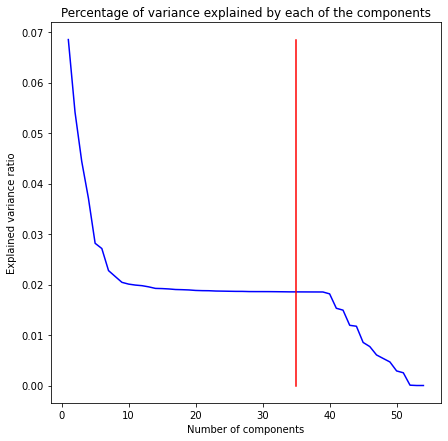

In [29]:
latent_space_size = estimate_latent_space_size(X_train, figure_id=1)

In [30]:
print(f'Latent space is {latent_space_size}.')

Latent space is 32.


In [31]:
BEST_RF_PARAMS = {'ccp_alpha': 1e-06, 'max_features': 0.8,
                  'max_samples': 0.9, 'n_estimators': 500}

In [32]:
if BEST_RF_PARAMS is None:
    baseline = find_best_rf(X_train, y_train)
else:
    baseline = RandomForestClassifier(
        random_state=42, verbose=True, n_jobs=-1,
        oob_score=True, bootstrap=True,
        ccp_alpha=BEST_RF_PARAMS['ccp_alpha'],
        n_estimators=BEST_RF_PARAMS['n_estimators'],
        max_samples=BEST_RF_PARAMS['max_samples'],
        max_features=BEST_RF_PARAMS['max_features']
    ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.3min finished


In [33]:
tree_depths = [cur_tree.get_depth() for cur_tree in baseline.estimators_]
tree_depths.sort()
print(f'Minimal tree depth is {tree_depths[0]}.')
print(f'Maximal tree depth is {tree_depths[-1]}.')
print(f'Median tree depth is {tree_depths[len(tree_depths) // 2]}.')
print(f'95% tree depth is {tree_depths[int(0.95 * (len(tree_depths) - 1))]}.')
print(f'Mean tree depth is {np.mean(tree_depths)}.')
encoder_depth = max(1, tree_depths[int(0.95 * (len(tree_depths) - 1))] // 3)

Minimal tree depth is 37.
Maximal tree depth is 50.
Median tree depth is 42.
95% tree depth is 46.
Mean tree depth is 41.754.


In [34]:
print(classification_report(y_true=y_valid, y_pred=baseline.predict(X_valid),
                            digits=4))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.7s


              precision    recall  f1-score   support

           0     0.9755    0.9675    0.9715     10063
           1     0.9720    0.9807    0.9763     13457
           2     0.9600    0.9747    0.9673      1698
           3     0.9308    0.8647    0.8966       451
           4     0.9530    0.9345    0.9437       825
           5     0.9782    0.9671    0.9726       974
           6     0.9286    0.8931    0.9105       131

    accuracy                         0.9713     27599
   macro avg     0.9569    0.9403    0.9484     27599
weighted avg     0.9713    0.9713    0.9713     27599



[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.9s finished


In [35]:
print(classification_report(y_true=y_test, y_pred=baseline.predict(X_test),
                            digits=4))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.7s


              precision    recall  f1-score   support

           0     0.9765    0.9675    0.9720     10592
           1     0.9717    0.9824    0.9770     14165
           2     0.9656    0.9737    0.9696      1788
           3     0.9624    0.8632    0.9101       475
           4     0.9459    0.9459    0.9459       868
           5     0.9762    0.9581    0.9670      1026
           6     0.9077    0.8613    0.8839       137

    accuracy                         0.9720     29051
   macro avg     0.9580    0.9360    0.9465     29051
weighted avg     0.9720    0.9720    0.9719     29051



[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.9s finished


In [36]:
del dataset

In [37]:
input_normalizer = build_normalizer(X_train)

In [38]:
X_train = input_normalizer.transform(X_train)
X_valid = input_normalizer.transform(X_valid)
X_test = input_normalizer.transform(X_test)

In [39]:
trainset_gen = TrainsetGenerator(
    x=X_train,
    y=y_train,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING
)

In [40]:
X_, y_ = trainset_gen[0]
print(X_[0])
for it in y_:
    print(it[0].tolist() if isinstance(it[0], np.ndarray) else it[0])
del X_, y_

[ 1.6481367e-01 -7.2752440e-01 -6.3458222e-01 -7.2056454e-01
  4.7534648e-01 -9.5588958e-01 -1.3696417e-01  2.2365841e-01
 -7.4220991e-01  1.8210919e+00 -1.2941617e+00  1.6701691e+00
 -1.4383140e+00  2.3334509e-01  2.5504935e-01 -7.6389384e-01
  2.8694868e-01 -4.9366906e-01 -7.4199474e-01 -4.3707731e-01
  1.3714510e-01 -5.5590701e-01 -1.6601421e-01 -1.1571726e-01
  1.7112322e-01  6.8379506e-02 -5.7876389e-02 -1.5353777e-01
  2.3908406e-02 -7.5148620e-02 -1.4304197e-02 -5.1669176e-03
 -1.1302061e-02  4.6780957e-03 -3.4525152e-02 -4.7401305e-02
 -1.7942935e-02  2.9622302e-03 -1.6188257e-03  1.6566034e-01
  1.3197633e+00 -2.2789581e-01  8.7245440e-01 -2.1616685e-01
 -8.9910114e-01 -1.8598354e+00 -1.6068684e-01 -9.7984111e-01
  2.0779929e+00  1.1571113e+00  2.1292517e+00  2.2986341e-02
 -1.4899393e+00 -2.0786524e+00]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.16481366753578186, -0.7275243997573853, -0.6345822215080261, -0.7205645442008972, 0.47534647583961487, -0.9558895826339722, -0.136964172

In [41]:
train_class_freq = dict()
for idx1 in range(len(trainset_gen)):
    X_, y_ = trainset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in train_class_freq:
            train_class_freq[class_idx1] += 1
        else:
            train_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(train_class_freq.keys()):
    sum_freq += train_class_freq[class_idx1]
for class_idx1 in sorted(train_class_freq.keys()):
    percent = 100.0 * train_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 14%.
Class 1 frequency is 14%.
Class 2 frequency is 14%.
Class 3 frequency is 14%.
Class 4 frequency is 14%.
Class 5 frequency is 14%.
Class 6 frequency is 14%.


In [42]:
validset_gen = ValidsetGenerator(
    x=X_valid,
    y=y_valid,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING
)

In [43]:
val_class_freq = dict()
for idx1 in range(len(validset_gen)):
    X_, y_ = validset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in val_class_freq:
            val_class_freq[class_idx1] += 1
        else:
            val_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(val_class_freq.keys()):
    sum_freq += val_class_freq[class_idx1]
for class_idx1 in sorted(val_class_freq.keys()):
    percent = 100.0 * val_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 36%.
Class 1 frequency is 49%.
Class 2 frequency is 6%.
Class 3 frequency is 2%.
Class 4 frequency is 3%.
Class 5 frequency is 4%.
Class 6 frequency is 0%.


In [44]:
tf.keras.backend.clear_session()

In [45]:
trainable_nn, encoding_nn, classification_nn = build_neural_network(
    n_features=X_valid.shape[1], n_classes=len(classes_dict), depth=encoder_depth,
    n_latent=latent_space_size, n_hidden=HIDDEN_LAYER_SIZE, nn_name='covertype'
)

In [46]:
trainable_nn.summary()

Model: "covertype_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
covertype_feature_vector (Input [(None, 54)]         0                                            
__________________________________________________________________________________________________
covertype_enc_dense1 (Dense)    (None, 512)          28160       covertype_feature_vector[0][0]   
__________________________________________________________________________________________________
covertype_enc_dense2 (Dense)    (None, 512)          262656      covertype_enc_dense1[0][0]       
__________________________________________________________________________________________________
covertype_enc_dense3 (Dense)    (None, 512)          262656      covertype_enc_dense2[0][0]       
______________________________________________________________________________________

In [47]:
nn_fname = 'covertype_united.h5'

In [48]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=ES_PATIENCE,
        mode="min",
        restore_best_weights=False
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=nn_fname,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.33,
        patience=2,
        verbose=True,
        mode="min",
        monitor="loss"
    )
]

In [49]:
model_history = trainable_nn.fit(trainset_gen, validation_data=validset_gen,
                                 epochs=MAX_TRAINING_EPOCHS, callbacks=callbacks,
                                 verbose=1)

Epoch 1/2000
513/513 [==============================] - 311s 498ms/step - loss: 1.2955 - covertype_cls_loss: 0.9192 - covertype_reconstruction_loss: 0.1927 - covertype_cls_categorical_accuracy: 0.7669 - val_loss: 1.2725 - val_covertype_cls_loss: 0.9572 - val_covertype_reconstruction_loss: 0.1683 - val_covertype_cls_categorical_accuracy: 0.7440
Epoch 2/2000
513/513 [==============================] - 252s 491ms/step - loss: 0.9687 - covertype_cls_loss: 0.7288 - covertype_reconstruction_loss: 0.1189 - covertype_cls_categorical_accuracy: 0.8720 - val_loss: 1.0915 - val_covertype_cls_loss: 0.8341 - val_covertype_reconstruction_loss: 0.1401 - val_covertype_cls_categorical_accuracy: 0.8085
Epoch 3/2000
513/513 [==============================] - 252s 492ms/step - loss: 0.9813 - covertype_cls_loss: 0.7271 - covertype_reconstruction_loss: 0.1304 - covertype_cls_categorical_accuracy: 0.8743 - val_loss: 1.1664 - val_covertype_cls_loss: 0.8758 - val_covertype_reconstruction_loss: 0.1605 - val_cover

KeyboardInterrupt: 

In [ ]:
trainable_nn.load_weights(nn_fname)

In [ ]:
show_training_process(history=model_history, metric_name='loss',
                      figure_id=2)

In [ ]:
show_training_process(history=model_history, metric_name='covertype_cls_loss',
                      figure_id=3)

In [ ]:
show_training_process(history=model_history,
                      metric_name='covertype_cls_categorical_accuracy',
                      figure_id=4)

In [ ]:
del trainset_gen, validset_gen

In [ ]:
del X_train, y_train

In [ ]:
gc.collect()

In [ ]:
valid_probas = predict_proba(
    X=X_valid, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

In [ ]:
print(classification_report(y_true=y_valid, y_pred=np.argmax(valid_probas, axis=1),
                            digits=4))

In [ ]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

In [ ]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

In [ ]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=10, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

In [ ]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

In [ ]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=100, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

In [ ]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

In [ ]:
show_classes(
    features=reduce_dimensions_of_data(X_test),
    targets=y_test,
    class_colors=COLORS_OF_CLASSES,
    title='source inputs',
    figure_id=5
)

In [ ]:
show_classes(
    features=reduce_dimensions_of_data(
        reconstruct_inputs(
            X=X_test,
            vae=trainable_nn,
            batch_size=MINIBATCH_SIZE_FOR_INFERENCE
        )
    ),
    targets=y_test,
    class_colors=COLORS_OF_CLASSES,
    title='reconstructed inputs',
    figure_id=6
)

In [ ]:
show_classes(
    features=reduce_dimensions_of_data(
        calculate_projections(
            X=X_test,
            encoder=encoding_nn,
            n_samples=1,
            batch_size=MINIBATCH_SIZE_FOR_INFERENCE
        )[0]
    ),
    targets=y_test,
    class_colors=COLORS_OF_CLASSES,
    title='latent variables',
    figure_id=7
)